I'm going to try my best to make this functional.

In [5]:
#  !pip install --upgrade pip setuptools==57.5.0
#  !pip install regressors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
arviz 0.15.1 requires setuptools>=60.0.0, but you have setuptools 57.5.0 which is incompatible.
cvxpy 1.3.2 requires setuptools>65.5.1, but you have setuptools 57.5.0 which is incompatible.


  Preparing metadata (setup.py) ... done
  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12399 sha256=904ee4b313a76294fd892cda2a8a6b70f87dd2e087b076cd1c5865d980fa24e3
  Stored in directory: /root/.cache/pip/wheels/85/e8/ec/b8fe5e2d41af2f4760b0d8ce1ae8f01c78df5d1b0883dee2fe
Successfully built regressors


# Imports and Housekeeping

In [2]:
# Basic Packages
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime as dt

# Visualizations
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Modeling
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from regressors import stats
import statsmodels.api as sm

# Neural Net stuff
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# for building and training neural networks
import tensorflow as tf

# custom functions

In [3]:
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)

# reduce display precision on numpy arrays
np.set_printoptions(precision=2)

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

C:\Users\Sleepycornbread\AppData\Local\Temp\ipykernel_25624\4246722715.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Get Data

This is from a python API. All of the API work and data manipulation was done in PyCharm and can be found on Github

In [4]:
df = pd.read_csv("Data/Model Data/final_data.csv", index_col=0)
min_max_scaler = MinMaxScaler()

In [14]:
df.columns


Index(['game_id', 'season', 'week', 'team', 'opponent', 'score', 'home',
       'ewma_dynamic_window_rushing_offense_team',
       'ewma_dynamic_window_passing_offense_team',
       'ewma_dynamic_window_rushing_defense_team',
       'ewma_dynamic_window_passing_defense_team',
       'ewma_dynamic_window_rushing_offense_opp',
       'ewma_dynamic_window_passing_offense_opp',
       'ewma_dynamic_window_rushing_defense_opp',
       'ewma_dynamic_window_passing_defense_opp', 'team_id',
       'rest_differential', 'windy', 'div_game', 'spread_line',
       'implied_points', 'total_line', 'game_type', 'location', 'total'],
      dtype='object')

# Creating Functions for model setup, modeling, and charting

Creating two functions. 1 that graphs a model, and one that creates the model. The graph will just be a helper function in the modeling function. This is just for linear regression

In [7]:
def graph_linear_model(y_pred, y_test, r2="NA", mse="NA", title="NA", xlabel="NA", ylabel="NA"):
  # set x and y
  x = y_pred.flatten()
  y = y_test

  # calculate equation for trendline
  z = np.polyfit(x, y, 1)
  p = np.poly1d(z)

  # Create the subplot function
  fig, ax = plt.subplots()

  # Plot the scatter
  ax.scatter(x,y)

  # Plot the trendline
  ax.plot(x, p(x), color="red")

  # Titles and axes
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  # Plotting some text
  plt.annotate('R-squared = %0.4f' % r2, xy=(0.025, 0.95), xycoords='axes fraction')
  plt.annotate("y = %.2fx + %.2f"%(z[0],z[1]), xy=(0.025, 0.90), xycoords='axes fraction')
  plt.annotate(f"MSE = {mse: .3f}", xy=(0.025, 0.85), xycoords='axes fraction')

In [8]:
def make_predictions(df, clf, features):
  df_2020 = df.loc[(df['season'] == 2020)].assign(
    predicted_winner = lambda x: clf.predict(x[features]),
    home_team_win_probability = lambda x: clf.predict_proba(x[features])[:, 1]
  )\
  [['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

  df_2020['actual_winner'] = df_2020.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
  df_2020['predicted_winner'] = df_2020.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
  df_2020['win_probability'] = df_2020.apply(lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
  df_2020['correct_prediction'] = (df_2020['predicted_winner'] == df_2020['actual_winner']).astype(int)

  df_2020 = df_2020.drop(columns=['home_team_win_probability', 'home_team_win'])

  df_2020.sort_values(by='win_probability', ascending=False).reset_index(drop=True).head(10)
  df_2020.sort_values(by='win_probability', ascending=False, inplace=True)
  return df_2020

In [9]:
def linear_regression(df, target, feature_list, title="", xlabel="", ylabel=""):
  # Dropping NA's and the 2020 season because covid and testing
  df_l = df.dropna(inplace=True)
  df_l = df.loc[df['season'] != 2020]
  print(df_l.isna().values.any())

  # Defining features & target
  x = np.array(df_l[feature_list])
  y = np.array(df_l[target])

  # Normalizing the Data
  x_scaled = min_max_scaler.fit_transform(x)

  # Creating train test split. Test will be 20% of the data
  X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=10)

  # Create Regression object and fit
  clf = LinearRegression()
  clf.fit(X_train, y_train)

  # Make a prediction based on the fit. Use X_test (20% of the data)
  y_pred = clf.predict(X_test)

  # Get some info about the coefficients and how they're impacting the model
  mod = sm.OLS(y_train,X_train)
  fii = mod.fit()

  # Getting some info for graphing later
  r2 = fii.rsquared
  mse = mean_squared_error(y_pred, y_test)

  summary = fii.summary()

  # Call graphing function to output graph
  graph_linear_model(y_pred, y_test, r2, mse, title, xlabel, ylabel)

  return summary

In [10]:
def logistic_regression(df, target, feature_list, title="", xlabel="", ylabel=""):
    # Dropping NA's and the 2020 season because covid and testing
    df_l = df.dropna(inplace=True)
    df_l = df.loc[df['season'] != 2020]

    # Defining features & target
    x = df_l[target]
    y = df_l[feature_list]

    # Creating train test split. Test will be 20% of the data
    X_train, X_test, y_train, y_test = train_test_split(y, x, test_size=0.2, random_state=10)

    # Create Regression object and fit
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    # Make a prediction based on the fit. Use X_test (20% of the data)
    y_pred = clf.predict(X_test)

    # Get some info about the coefficients and how they're impacting the model
    mod = sm.Logit(y_train,X_train)
    fii = mod.fit()

    # Getting some info for graphing later
    mse = mean_squared_error(y_pred, y_test)

    summary = fii.summary()

    # Plotting - we don't need a separate function for this one
    sns.regplot(x=y_pred, y=y_test, data=df, logistic=True)

    # Call make predicitons function
    predictions = make_predictions(df, clf, features=feature_list)

    return summary, predictions

Okay, we created the functions. Now lets define the feature list for the spread model and the total model. These can now easily be adjusted to add or remove variables

In [11]:
spread_feature_list = ['ewma_dynamic_window_rushing_offense_team',
       'ewma_dynamic_window_passing_offense_team',
       'ewma_dynamic_window_rushing_defense_opp',
       'ewma_dynamic_window_passing_defense_opp',
       'home', 'rest_differential', 'windy', 'div_game' ]

Great, now we can just use our function to run different models for our predictions and then compare to the vegas line. Our goal is to beat their line

False


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.851
Model:                            OLS   Adj. R-squared (uncentered):              0.850
Method:                 Least Squares   F-statistic:                              613.8
Date:                Thu, 07 Sep 2023   Prob (F-statistic):                        0.00
Time:                        12:33:31   Log-Likelihood:                         -3182.7
No. Observations:                 868   AIC:                                      6381.
Df Residuals:                     860   BIC:                                      6419.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             8.4954      1.974      4.305      0.000       4.622      12.369
x2            20.5226      2.037     10.074      0.000      16.524      24.521
x3            -0.2209      1.956     -0.113      0.910      -4.061       3.619
x4             7.7621      2.142      3.624      0.000       3.558      11.966
x5             2.2402      0.643      3.485      0.001       0.978       3.502
x6             1.7842      2.049      0.871      0.384      -2.237       5.806
x7            -3.6934      1.292     -2.858      0.004      -6.230      -1.157
x8            -0.6727      0.668     -1.007      0.314      -1.984       0.639
==============================================================================
Omnibus:                        6.660   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                6.543
Skew:                           0.197   Prob(JB):                       0.0379
Kurtosis:                       3.161   Cond. No.                         10.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

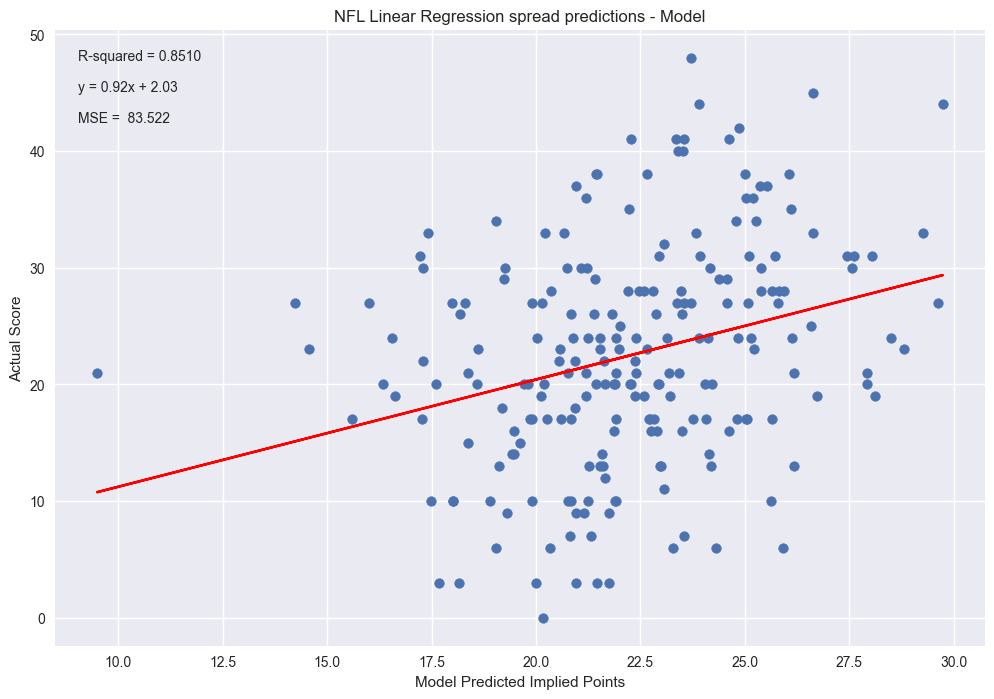

In [12]:
linR_spread_model = linear_regression(df, target="score", feature_list=spread_feature_list,
                                             title="NFL Linear Regression spread predictions - Model",
                                             xlabel="Model Predicted Implied Points", ylabel="Actual Score")
linR_spread_model